In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [2]:
def EPM_bipartite_graph_generator_igraph(num_system, num_ancilla, type):
    """
    igraph를 사용한 EPM 이분 그래프 생성기
    
    Parameters:
    -----------
    num_system : int
        시스템 노드 수
    num_ancilla : int
        앵커라 노드 수
    type : int
        그래프 유형
        
    Yields:
    -------
    igraph.Graph
        생성된 이분 그래프
    """
    import igraph as ig
    import itertools
    
    num_total = num_system + num_ancilla
    
    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)
    
    # ancilla 조합 생성
    if num_ancilla > 0:
        ancilla_combinations_pre = generate_combinations(num_total)
        ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))
    
    for rb_comb in red_blue_combinations:
        if num_ancilla > 0:
            for bl_comb in ancilla_combinations:
                # 노드 이름 생성
                system_node_names = [f'S_{i}' for i in range(num_system)]
                ancilla_node_names = [f'A_{i}' for i in range(num_ancilla)]
                sculpting_node_names = [str(i) for i in range(num_total)]
                
                # 모든 노드 이름 리스트
                all_node_names = system_node_names + ancilla_node_names + sculpting_node_names
                
                # igraph 그래프 생성
                G = ig.Graph()
                G.add_vertices(len(all_node_names))
                
                # 노드 이름 및 속성 설정
                G.vs["name"] = all_node_names
                
                # 노드 카테고리 설정
                categories = ["system_nodes"] * num_system + ["ancilla_nodes"] * num_ancilla + ["sculpting_nodes"] * num_total
                G.vs["category"] = categories
                
                # 이분 그래프 타입 설정 (0: 왼쪽 파티션, 1: 오른쪽 파티션)
                bipartite_types = [0] * (num_system + num_ancilla) + [1] * num_total
                G.vs["bipartite"] = bipartite_types
                
                # 엣지 생성을 위한 리스트
                edges = []
                edge_weights = []
                
                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red_idx = num_system + num_ancilla + vt[0]  # sculpting 노드 인덱스
                    blue_idx = num_system + num_ancilla + vt[1]  # sculpting 노드 인덱스
                    system_idx = rb_index  # system 노드 인덱스
                    
                    edges.append((system_idx, red_idx))
                    edge_weights.append(1.0)
                    
                    edges.append((system_idx, blue_idx))
                    edge_weights.append(2.0)
                
                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    ancilla_idx = num_system + anc_index  # ancilla 노드 인덱스
                    for vt_inx in vt_list:
                        sculpting_idx = num_system + num_ancilla + vt_inx  # sculpting 노드 인덱스
                        edges.append((ancilla_idx, sculpting_idx))
                        edge_weights.append(3.0)
                
                # 그래프에 엣지 추가
                G.add_edges(edges)
                G.es["weight"] = edge_weights
                
                # 각 노드가 최소 2개 이상의 이웃을 갖는지 확인
                if all(G.degree(v) >= 2 for v in range(G.vcount())):
                    yield G
        else:  # num_ancilla == 0 인 경우
            # 노드 이름 생성
            system_node_names = [f'S_{i}' for i in range(num_system)]
            sculpting_node_names = [str(i) for i in range(num_total)]
            
            # 모든 노드 이름 리스트
            all_node_names = system_node_names + sculpting_node_names
            
            # igraph 그래프 생성
            G = ig.Graph()
            G.add_vertices(len(all_node_names))
            
            # 노드 이름 및 속성 설정
            G.vs["name"] = all_node_names
            
            # 노드 카테고리 설정
            categories = ["system_nodes"] * num_system + ["sculpting_nodes"] * num_total
            G.vs["category"] = categories
            
            # 이분 그래프 타입 설정
            bipartite_types = [0] * num_system + [1] * num_total
            G.vs["bipartite"] = bipartite_types
            
            # 엣지 생성을 위한 리스트
            edges = []
            edge_weights = []
            
            # red-blue 엣지 추가
            for rb_index, vt in enumerate(rb_comb):
                red_idx = num_system + vt[0]  # sculpting 노드 인덱스
                blue_idx = num_system + vt[1]  # sculpting 노드 인덱스
                system_idx = rb_index  # system 노드 인덱스
                
                edges.append((system_idx, red_idx))
                edge_weights.append(1.0)
                
                edges.append((system_idx, blue_idx))
                edge_weights.append(2.0)
            
            # 그래프에 엣지 추가
            G.add_edges(edges)
            G.es["weight"] = edge_weights
            
            # 각 노드가 최소 2개 이상의 이웃을 갖는지 확인
            if all(G.degree(v) >= 2 for v in range(G.vcount())):
                yield G

# igraph와 NetworkX 그래프 간 변환 유틸리티 함수
def igraph_to_networkx(g_igraph):
    """igraph 그래프를 NetworkX 그래프로 변환"""
    import networkx as nx
    
    G_nx = nx.Graph()
    
    # 노드 추가
    for v in g_igraph.vs:
        node_attrs = {attr: v[attr] for attr in v.attribute_names()}
        G_nx.add_node(v["name"], **node_attrs)
    
    # 엣지 추가
    for e in g_igraph.es:
        source = g_igraph.vs[e.source]["name"]
        target = g_igraph.vs[e.target]["name"]
        edge_attrs = {attr: e[attr] for attr in e.attribute_names()}
        G_nx.add_edge(source, target, **edge_attrs)
    
    return G_nx

def networkx_to_igraph(G_nx):
    """NetworkX 그래프를 igraph 그래프로 변환"""
    import igraph as ig
    
    g_igraph = ig.Graph()
    
    # 노드 추가
    node_names = list(G_nx.nodes())
    g_igraph.add_vertices(len(node_names))
    g_igraph.vs["name"] = node_names
    
    # 노드 속성 추가
    for attr in set().union(*(d.keys() for n, d in G_nx.nodes(data=True))):
        if attr != "name":  # 이름은 이미 설정됨
            g_igraph.vs[attr] = [G_nx.nodes[n].get(attr) for n in node_names]
    
    # 엣지 추가
    edges = [(node_names.index(u), node_names.index(v)) for u, v in G_nx.edges()]
    g_igraph.add_edges(edges)
    
    # 엣지 속성 추가
    for attr in set().union(*(d.keys() for u, v, d in G_nx.edges(data=True))):
        g_igraph.es[attr] = [G_nx.get_edge_data(u, v).get(attr) for u, v in G_nx.edges()]
    
    return g_igraph

In [12]:
def weighted_bipartite_canonical_form(graph):
    # 이분 그래프 파티션 정보 가져오기
    bipartite_types = graph.vs["bipartite"]
    
    # 가중치 정보 (1.0, 2.0, 3.0) 가져오기
    weights = graph.es["weight"]
    
    # 엣지 리스트 가져오기
    edge_list = graph.get_edgelist()
    
    # 각 노드의 가중치 패턴 수집
    node_weight_patterns = []
    for v_idx in range(graph.vcount()):
        pattern = []
        for e_idx, (src, dst) in enumerate(edge_list):
            if src == v_idx or dst == v_idx:
                pattern.append(weights[e_idx])
        # 정렬하여 일관된 패턴 생성
        pattern.sort()
        node_weight_patterns.append(tuple(pattern))
    
    # 가중치 패턴을 정수로 매핑
    unique_patterns = list(set(node_weight_patterns))
    pattern_to_int = {pattern: i+2 for i, pattern in enumerate(unique_patterns)}  # 2부터 시작
    
    # 최종 색상 계산 (파티션 타입 + 가중치 패턴)
    colors = []
    for v_idx in range(graph.vcount()):
        # 기본 색상은 파티션 타입 (0 또는 1)
        base_color = bipartite_types[v_idx]
        # 가중치 패턴 색상 (2 이상의 정수)
        pattern_color = pattern_to_int[node_weight_patterns[v_idx]]
        # 파티션과 패턴을 조합 (파티션 * 1000 + 패턴)
        # 이렇게 하면 다른 파티션의 노드는 항상 다른 색상을 가짐
        combined_color = base_color * 1000 + pattern_color
        colors.append(combined_color)
    
    # 정수 색상으로 canonical permutation 계산
    perm = graph.canonical_permutation(color=colors)
    
    # 정렬 적용
    permuted = graph.permute_vertices(perm)
    
    # Canonical form: 인접 행렬 + 가중치 패턴
    adj_matrix = tuple(map(tuple, permuted.get_adjacency().data))
    weight_pattern = tuple(permuted.es["weight"])
    
    return (adj_matrix, weight_pattern)

In [ ]:
# def remove_isomorphic_graphs(graph_list):
#     unique_graphs = []
#     canonical_forms = {}
    
#     for i, graph in enumerate(graph_list):
#         # 가중치 고려한 canonical form 계산
#         canonical_form = weighted_bipartite_canonical_form(graph)
        
#         # 이미 본 canonical form인지 확인
#         if canonical_form not in canonical_forms:
#             canonical_forms[canonical_form] = i
#             unique_graphs.append(graph)
    
#     return unique_graphs

def get_unique_graphs(graph_list):
    unique_graphs = {}  # canonical_form -> graph 매핑
    
    for graph in graph_list:
        # 가중치 고려한 canonical form 계산
        canonical_form = weighted_bipartite_canonical_form(graph)
        
        # 해당 canonical form을 가진 그래프가 없으면 추가
        if canonical_form not in unique_graphs:
            unique_graphs[canonical_form] = graph
    
    # 유일한 그래프들만 반환
    return list(unique_graphs.values())

In [14]:
# EPM 이분 그래프 생성
all_graphs = list(EPM_bipartite_graph_generator_igraph(3, 1, 0))
print(f"생성된 총 그래프 수: {len(all_graphs)}")

생성된 총 그래프 수: 3264


In [15]:
# 동형 그래프 제거
unique_graphs = remove_isomorphic_graphs(all_graphs)
print(f"유일한 그래프 수: {len(unique_graphs)}")

유일한 그래프 수: 27


동일한 걸 혹시 변경된게 있을까봐 다시 작성한것

In [22]:
# 가중치를 고려한 canonical form 함수는 그대로 유지
def weighted_bipartite_canonical_form(graph):
    # 이분 그래프 파티션 정보 가져오기
    bipartite_types = graph.vs["bipartite"]
    
    # 가중치 정보 (1.0, 2.0, 3.0) 가져오기
    weights = graph.es["weight"]
    
    # 엣지 리스트 가져오기
    edge_list = graph.get_edgelist()
    
    # 각 노드의 가중치 패턴 수집
    node_weight_patterns = []
    for v_idx in range(graph.vcount()):
        pattern = []
        for e_idx, (src, dst) in enumerate(edge_list):
            if src == v_idx or dst == v_idx:
                pattern.append(weights[e_idx])
        # 정렬하여 일관된 패턴 생성
        pattern.sort()
        node_weight_patterns.append(tuple(pattern))
    
    # 가중치 패턴을 정수로 매핑
    unique_patterns = list(set(node_weight_patterns))
    pattern_to_int = {pattern: i+2 for i, pattern in enumerate(unique_patterns)}  # 2부터 시작
    
    # 최종 색상 계산 (파티션 타입 + 가중치 패턴)
    colors = []
    for v_idx in range(graph.vcount()):
        # 기본 색상은 파티션 타입 (0 또는 1)
        base_color = bipartite_types[v_idx]
        # 가중치 패턴 색상 (2 이상의 정수)
        pattern_color = pattern_to_int[node_weight_patterns[v_idx]]
        # 파티션과 패턴을 조합 (파티션 * 1000 + 패턴)
        combined_color = base_color * 1000 + pattern_color
        colors.append(combined_color)
    
    # 정수 색상으로 canonical permutation 계산
    perm = graph.canonical_permutation(color=colors)
    
    # 정렬 적용
    permuted = graph.permute_vertices(perm)
    
    # Canonical form: 인접 행렬 + 가중치 패턴
    adj_matrix = tuple(map(tuple, permuted.get_adjacency().data))
    weight_pattern = tuple(permuted.es["weight"])
    
    return (adj_matrix, weight_pattern)

# 이 함수는 기존 remove_isomorphic_graphs 함수를 대체합니다
def get_unique_graphs(graph_list):
    unique_graphs = {}  # canonical_form -> graph 매핑
    
    for graph in graph_list:
        # 가중치 고려한 canonical form 계산
        canonical_form = weighted_bipartite_canonical_form(graph)
        
        # 해당 canonical form을 가진 그래프가 없으면 추가
        if canonical_form not in unique_graphs:
            unique_graphs[canonical_form] = graph
    
    # 유일한 그래프들만 반환
    return list(unique_graphs.values())

# 사용 예시:
# EPM 이분 그래프 생성
all_graphs = list(EPM_bipartite_graph_generator_igraph(3, 1, 0))
print(f"생성된 총 그래프 수: {len(all_graphs)}")

# 이 부분을 변경: remove_isomorphic_graphs 대신 get_unique_graphs 사용
unique_graphs = get_unique_graphs(all_graphs)
print(f"유일한 그래프 수: {len(unique_graphs)}")

생성된 총 그래프 수: 3264
유일한 그래프 수: 27


In [37]:
len(all_graphs)

3264

In [28]:
weighted_bipartite_canonical_form(all_graphs[0])

(((0, 0, 0, 0, 1, 0, 1, 0),
  (0, 0, 0, 0, 1, 0, 1, 0),
  (0, 0, 0, 0, 0, 1, 0, 1),
  (0, 0, 0, 0, 0, 1, 0, 1),
  (1, 1, 0, 0, 0, 0, 0, 0),
  (0, 0, 1, 1, 0, 0, 0, 0),
  (1, 1, 0, 0, 0, 0, 0, 0),
  (0, 0, 1, 1, 0, 0, 0, 0)),
 (1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 3.0))

In [29]:
weighted_bipartite_canonical_form(all_graphs[1])

(((0, 0, 0, 0, 1, 0, 1, 0),
  (0, 0, 0, 0, 1, 0, 1, 0),
  (0, 0, 0, 0, 0, 1, 0, 1),
  (0, 0, 0, 0, 1, 1, 0, 1),
  (1, 1, 0, 1, 0, 0, 0, 0),
  (0, 0, 1, 1, 0, 0, 0, 0),
  (1, 1, 0, 0, 0, 0, 0, 0),
  (0, 0, 1, 1, 0, 0, 0, 0)),
 (1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 3.0, 3.0))

In [56]:
len(unique_graphs)

27

In [57]:
unique_graphs

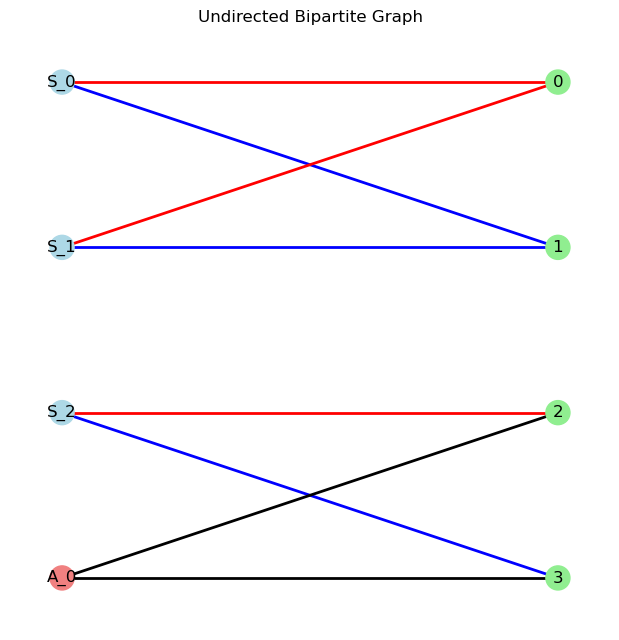

In [58]:
Draw_EPM_bipartite_graph(igraph_to_networkx(unique_graphs[0]))

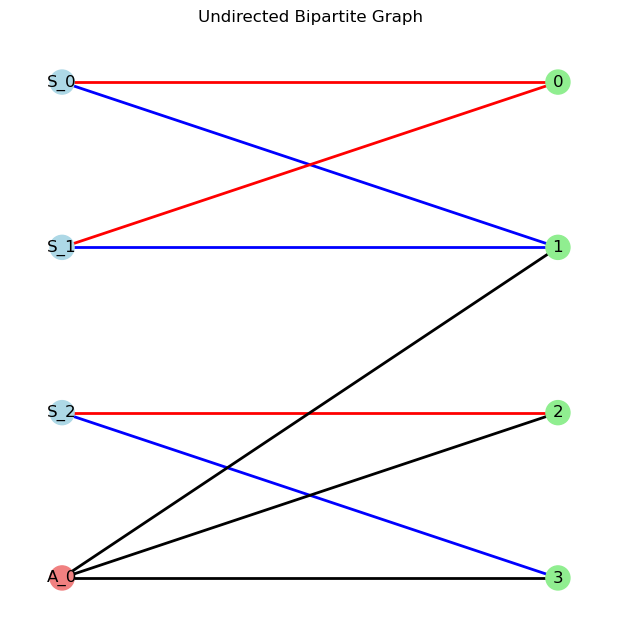

In [42]:
Draw_EPM_bipartite_graph(igraph_to_networkx(all_graphs[2]))

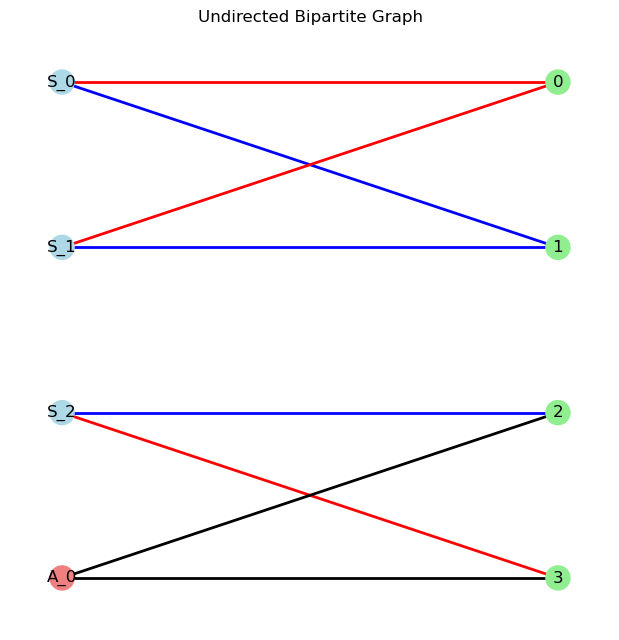

In [40]:
Draw_EPM_bipartite_graph(igraph_to_networkx(all_graphs[4]))

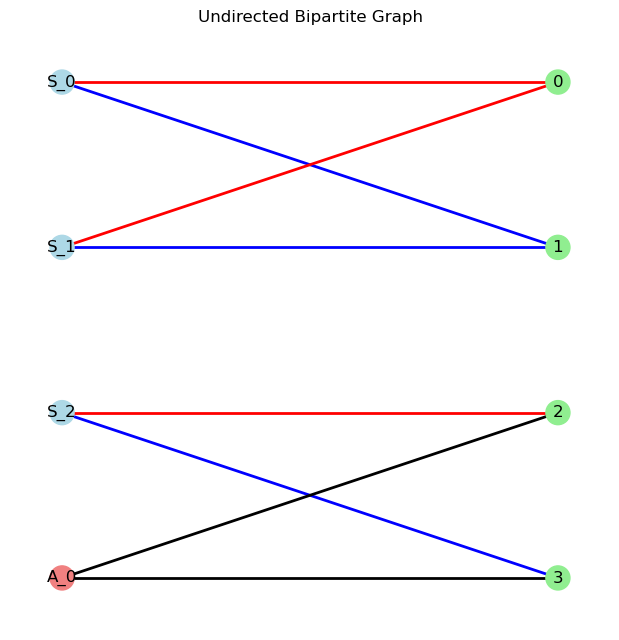

In [41]:
Draw_EPM_bipartite_graph(igraph_to_networkx(all_graphs[0]))